# TP FINAL -  Nivel Intermedio - Gastón Vernhes - 04/11/20

IDEA: ver la sorpresa en los earnings (real vs estimado) y compararlo con la variacion de precio del dia
* datos historicos > Yahoo Finance
* earnings > Api FMP

## Importamos las Librerias

In [1]:
import requests
import pandas as pd
import yfinance as yf
import tqdm, sys, os
import numpy as np
import sqlite3
import datetime as dt
import matplotlib.pyplot as plt

#me conecto a SQL
from sqlalchemy import create_engine
sql_engine = create_engine('mysql+pymysql://root:@localhost/tp_final_niv_intermedio')
sql_conn = sql_engine.connect()

## PASO 1: Descarga datos históricos

### Descargamos los datos históricos de Yahoo Finance

In [ ]:
#Armamos la lista de tickers
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [t for t in sp500_tickers if t not in ['BRK.B' ,'BF.B']]

#Creamos la funcion para bajar los datos
def getDataM(listado, start='2000-01-01', interval='1d', end=None):
    data = yf.download(listado, start=start, end=end, interval=interval, auto_adjust=True)
    return data.swaplevel(i=1, j=0, axis=1)

In [29]:
#Paso los tickers a un DF para luego guardarlo en SQL
sp500_tickers = pd.DataFrame(sp500_tickers)
sp500_tickers.columns = ['Symbol']

In [2]:
%%time
#descargo los datos
df_sp500 = getDataM(sp500_tickers)

[*********************100%***********************]  503 of 503 completed
Wall time: 1min 15s


In [11]:
#Tomamos solo los precios de cierre

precios_cierre_sp500 = df_sp500.copy()
precios_cierre_sp500 = precios_cierre_sp500.swaplevel(i=1, j=0, axis=1)['Close']
precios_cierre_sp500

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,44.603386,NaN,NaN,0.863657,NaN,2.968561,18.250000,6.517454,NaN,16.274673,...,33.169758,20.730383,6.922205,50.373814,NaN,4.988526,NaN,25.027779,40.342747,NaN
2000-01-04,41.196171,NaN,NaN,0.790842,NaN,2.765887,17.812500,6.331241,NaN,14.909401,...,32.415897,20.333307,6.922205,48.030865,NaN,4.888254,NaN,24.666666,38.389206,NaN
2000-01-05,38.640766,NaN,NaN,0.802415,NaN,2.980481,18.000000,6.319605,NaN,15.204173,...,31.706371,21.441793,7.041870,50.503986,NaN,4.913321,NaN,25.138889,38.343781,NaN
2000-01-06,37.169479,NaN,NaN,0.732975,NaN,3.206998,18.031250,6.540730,NaN,15.328290,...,28.957006,22.550280,7.051075,49.462685,NaN,4.871542,NaN,23.777779,38.888947,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,104.629997,11.80,151.210007,115.050003,83.919998,98.370003,288.320007,109.000000,219.229996,475.200012,...,114.550003,33.349998,47.610001,18.920000,90.070000,99.199997,139.509995,295.100006,32.459999,160.479996
2020-10-27,106.040001,11.23,150.410004,116.599998,82.709999,97.650002,290.510010,108.580002,220.660004,478.559998,...,124.349998,32.820000,47.540001,18.520000,89.059998,97.989998,138.600006,289.279999,31.080000,162.470001
2020-10-28,101.660004,10.95,146.380005,111.199997,80.489998,95.699997,283.000000,106.419998,213.940002,456.970001,...,119.760002,31.570000,44.840000,17.230000,87.349998,95.059998,133.369995,285.200012,30.600000,158.690002


#### Chequeo los datos

In [12]:
precios_cierre_sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5252 entries, 1999-12-31 to 2020-10-30
Columns: 503 entries, A to ZTS
dtypes: float64(503)
memory usage: 20.2 MB


#### Armamos una tabla de las variaciones porcentuales

In [15]:
var_porcentual_sp500 = precios_cierre_sp500.pct_change() * 100
var_porcentual_sp500

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-7.638916,NaN,NaN,-8.431051,NaN,-6.827322,-2.397260,-2.857136,NaN,-8.388940,...,-2.272734,-1.915428,0.000000,-4.651125,NaN,-2.010056,NaN,-1.442847,-4.842359,NaN
2000-01-05,-6.203015,NaN,NaN,1.463433,NaN,7.758573,1.052632,-0.183791,NaN,1.977089,...,-2.188821,5.451578,1.728700,5.149026,NaN,0.512817,NaN,1.914419,-0.118329,NaN
2000-01-06,-3.807602,NaN,NaN,-8.653855,NaN,7.600030,0.173611,3.499042,NaN,0.816334,...,-8.671332,5.169746,0.130723,-2.061821,NaN,-0.850322,NaN,-5.414363,1.421785,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,-1.450505,-6.349208,-2.268611,0.008694,-0.497982,-1.016296,2.451849,1.122552,-4.558120,-2.722618,...,-1.943158,-2.371198,-3.133267,-4.105421,-1.659566,-2.053714,-2.242318,-2.838139,-2.228921,-1.841097
2020-10-27,1.347609,-4.830514,-0.529068,1.347236,-1.441848,-0.731932,0.759574,-0.385319,0.652287,0.707068,...,8.555212,-1.589202,-0.147027,-2.114163,-1.121352,-1.219757,-0.652275,-1.972215,-4.251384,1.240033
2020-10-28,-4.130514,-2.493319,-2.679342,-4.631219,-2.684078,-1.996932,-2.585112,-1.989320,-3.045410,-4.511450,...,-3.691191,-3.808653,-5.679429,-6.965448,-1.920053,-2.990101,-3.773457,-1.410394,-1.544400,-2.326583


#### Paso las variaciones a un DF con la informacion en las filas

In [58]:
%%time
#tickers = ['A', 'AAL', 'ABBV']
tickers = var_porcentual_sp500.columns[1:]  #empiezo desde el 1, xq el 0 es la columna "Date"

var_porcentual_sp500_ok = pd.DataFrame() #nuevo dataframe vacio 

df = var_porcentual_sp500.copy()
df = df.loc[df.Date > '2018-01-01']  #hago un corte de fecha, xq los earnings que consegui son de los ultimos 2 años aprox, sino el DF a guardar en SQL tiene 2.5MM de filas

for ticker in tickers:
    df2 = df[['Date',ticker]]                       #tomo del DF solo la fecha y la columna del ticker
    df2 = df2.rename(columns={ticker: 'Var_porct'})  #cambio el nombre de la columna, para que no quede el nombre del ticker. Este paso es fundamental para que concatene todo en filas, y no en columnas
    df2['Symbol'] = ticker
    var_porcentual_sp500_ok = pd.concat([var_porcentual_sp500_ok, df2], axis = 0)
    print(ticker, end= ', ')

A, AAL, AAP, AAPL, ABBV, ABC, ABMD, ABT, ACN, ADBE, ADI, ADM, ADP, ADSK, AEE, AEP, AES, AFL, AIG, AIV, AIZ, AJG, AKAM, ALB, ALGN, ALK, ALL, ALLE, ALXN, AMAT, AMCR, AMD, AME, AMGN, AMP, AMT, AMZN, ANET, ANSS, ANTM, AON, AOS, APA, APD, APH, APTV, ARE, ATO, ATVI, AVB, AVGO, AVY, AWK, AXP, AZO, BA, BAC, BAX, BBY, BDX, BEN, BIIB, BIO, BK, BKNG, BKR, BLK, BLL, BMY, BR, BSX, BWA, BXP, C, CAG, CAH, CARR, CAT, CB, CBOE, CBRE, CCI, CCL, CDNS, CDW, CE, CERN, CF, CFG, CHD, CHRW, CHTR, CI, CINF, CL, CLX, CMA, CMCSA, CME, CMG, CMI, CMS, CNC, CNP, COF, COG, COO, COP, COST, CPB, CPRT, CRM, CSCO, CSX, CTAS, CTLT, CTSH, CTVA, CTXS, CVS, CVX, CXO, D, DAL, DD, DE, DFS, DG, DGX, DHI, DHR, DIS, DISCA, DISCK, DISH, DLR, DLTR, DOV, DOW, DPZ, DRE, DRI, DTE, DUK, DVA, DVN, DXC, DXCM, EA, EBAY, ECL, ED, EFX, EIX, EL, EMN, EMR, EOG, EQIX, EQR, ES, ESS, ETN, ETR, ETSY, EVRG, EW, EXC, EXPD, EXPE, EXR, F, FANG, FAST, FB, FBHS, FCX, FDX, FE, FFIV, FIS, FISV, FITB, FLIR, FLS, FLT, FMC, FOX, FOXA, FRC, FRT, FTI, FTNT, 

In [59]:
var_porcentual_sp500_ok

,Date,Var_porct,Symbol
4537,2018-01-02,0.940700,A
4538,2018-01-03,2.544392,A
4539,2018-01-04,-0.750144,A
4540,2018-01-05,1.598831,A
4541,2018-01-08,0.214600,A
...,...,...,...
5247,2020-10-26,-1.841097,ZTS
5248,2020-10-27,1.240033,ZTS
5249,2020-10-28,-2.326583,ZTS
5250,2020-10-29,1.575399,ZTS


### Guardamos las tablas en SQL

In [61]:
from sqlalchemy import create_engine
sql_engine = create_engine('mysql+pymysql://root:@localhost/tp_final_niv_intermedio')
sql_conn = sql_engine.connect()

In [31]:
%%time
sp500_tickers.to_sql(con=sql_conn, name='sp500_tickers', if_exists='replace')
precios_cierre_sp500.to_sql(con=sql_conn, name='precios_cierre_sp500', if_exists='replace')
var_porcentual_sp500.to_sql(con=sql_conn, name='var_porcentual_sp500', if_exists='replace')

Wall time: 54.1 s


In [62]:
%%time
#guardo la tabla retocada de las variaciones
var_porcentual_sp500_ok.to_sql(con=sql_conn, name='var_porcentual_sp500_ok', if_exists='replace')

Wall time: 16min 21s


### Traigo las tablas de SQL

In [2]:
%%time
from sqlalchemy import create_engine

#me conecto a SQL
sql_engine = create_engine('mysql+pymysql://root:@localhost/tp_final_niv_intermedio')
sql_conn = sql_engine.connect()

#traigo las tablas de SQL
sp500_tickers = pd.read_sql('SELECT * FROM sp500_tickers', sql_conn)
precios_cierre_sp500 = pd.read_sql('SELECT * FROM precios_cierre_sp500', sql_conn)
var_porcentual_sp500 = pd.read_sql('SELECT * FROM var_porcentual_sp500', sql_conn)
var_porcentual_sp500_ok = pd.read_sql('SELECT * FROM var_porcentual_sp500_ok', sql_conn)

Wall time: 41.5 s


----------------------------------------------------------------------------------------------------------------

## PASO 2: Descarga earnings estimados y reales de FMP

### Descargo varios apikeys

In [5]:
#por cada apikey tenes 250 requests disponibles

apikey = '71f98dbac30d70f278f676ecd1de9c5b'
apikey2 = '337abc1df0b89ae1159b2039bb777cbc'
apikey3 = 'add1fd21bf7653509ff508e841db80ef'
apikey4 = '16354d6d742ee6a0a68e9526add374d7'
apikey5 = '8ea3a12979a22275232c778154e32ec4'

apikeys = [apikey, apikey2, apikey3, apikey4, apikey5]

### Creo función para descargar los earnings

In [3]:
def getEarnings(ticker, apikey):
    url = 'https://fmpcloud.io/api/v3/earnings-surpises/'+ticker
    p = {'apikey': apikey}
    r = requests.get(url, params = p)
    js = r.json()
    df = pd.DataFrame(js)
    df = df.rename(columns={'symbol': 'Symbol'})
    #df.set_index('symbol', inplace=True)
    return df

In [6]:
df = getEarnings('AAPL', apikey5)
df

,date,Symbol,actualEarningResult,estimatedEarning
0,2020-10-29,AAPL,0.73,0.70
1,2020-07-30,AAPL,0.65,0.51
2,2020-04-30,AAPL,0.64,0.56
3,2020-01-28,AAPL,1.25,1.14
4,2019-10-30,AAPL,0.76,0.71
5,2019-07-30,AAPL,0.55,0.53
6,2019-04-30,AAPL,0.62,0.59
7,2019-01-29,AAPL,1.05,1.04
8,2018-11-01,AAPL,0.73,0.70


#### Chequeo los datos

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 9 non-null      object 
 1   Symbol               9 non-null      object 
 2   actualEarningResult  9 non-null      float64
 3   estimatedEarning     9 non-null      float64
dtypes: float64(2), object(2)
memory usage: 416.0+ bytes


##### Paso la fecha a formato Datetime

In [8]:
#paso la fecha a formato datetime
df['date'] = pd.to_datetime(df['date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 9 non-null      datetime64[ns]
 1   Symbol               9 non-null      object        
 2   actualEarningResult  9 non-null      float64       
 3   estimatedEarning     9 non-null      float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 416.0+ bytes


### Rearmo la funcion de earnings con el formato fecha y variación sorpresa

In [3]:
def getEarnings(ticker, apikey):
    url = 'https://fmpcloud.io/api/v3/earnings-surpises/'+ticker
    p = {'apikey': apikey}
    r = requests.get(url, params = p)
    js = r.json()
    
    #Hay 3 posibilidades:
    #       1) que no encuentre el ticker, el json viene vacio
    #       2) que funcione el apikey y encuentre el ticker, el json viene con datos 
    #       3) que no funcione el apikey, el json devuelve un mensaje de 'Limit Reach', el json viene con 1 dato
    
    
    if len(js) == 0:            
        df = pd.DataFrame()
        msg = f'No se encontró el ticker {ticker}'
    elif len(js) > 0:
        #Armo un try/except para saber cuándo se terminan los requests en una apikey
        try:
            df = pd.DataFrame(js)
            df = df.rename(columns={'symbol': 'Symbol'})  #renombre a Symbol para que coincida con las otras tablas
            df['date'] = pd.to_datetime(df['date'])       #pasa la fecha a datetime
            df['Var_Sorpresa'] = round((df.actualEarningResult / df.estimatedEarning - 1) * 100, 2)
            #df.set_index('symbol', inplace=True)
            msg = 'Todo ok'
        except:
            df = pd.DataFrame()
            msg = js['Error Message'][0:11]  # devuelve 'Limit Reach'
        
    return df, msg

### Descargo los earnings de todos los tickers del S&P500 que estaban en SQL

#### Error por cantidad de requests a la API

In [7]:
%%time

tickers = list(sp500_tickers.Symbol)
apikeys = [apikey, apikey2, apikey3, apikey4, apikey5]

earnings_sp500 = pd.DataFrame()

for ticker in tickers:
    for apikey in apikeys:
        
        df, msg = getEarnings(ticker, apikey) #se descarga la información
       
        if msg == 'Limit Reach':
            pass
        elif msg == 'Todo ok':
            print(ticker, end= ', ')
            break 
        else: 
            print(f'\n**** No se encontró el ticker {ticker} ****')
            break
            
    earnings_sp500 = pd.concat([earnings_sp500,df])

earnings_sp500

MMM, ABT, ABBV, ABMD, ACN, ATVI, ADBE, AMD, AAP, AES, AFL, A, APD, AKAM, ALK, ALB, ARE, ALXN, ALGN, ALLE, LNT, ALL, GOOGL, GOOG, MO, AMZN, AMCR, AEE, AAL, AEP, AXP, AIG, AMT, AWK, AMP, ABC, AME, AMGN, APH, ADI, ANSS, ANTM, AON, AOS, APA, AIV, AAPL, AMAT, APTV, ADM, ANET, AJG, AIZ, T, ATO, ADSK, ADP, AZO, AVB, AVY, BKR, BLL, BAC, BK, BAX, BDX, BBY, BIO, BIIB, BLK, BA, BKNG, BWA, BXP, BSX, BMY, AVGO, BR, CHRW, COG, CDNS, CPB, COF, CAH, KMX, CCL, CARR, CTLT, CAT, CBOE, CBRE, CDW, CE, CNC, CNP, CERN, CF, SCHW, CHTR, CVX, CMG, CB, CHD, CI, CINF, CTAS, CSCO, C, CFG, CTXS, CLX, CME, CMS, KO, CTSH, CL, CMCSA, CMA, CAG, CXO, COP, ED, STZ, COO, CPRT, GLW, CTVA, COST, CCI, CSX, CMI, CVS, DHI, DHR, DRI, DVA, DE, DAL, XRAY, DVN, DXCM, FANG, DLR, DFS, DISCA, DISCK, DISH, DG, DLTR, D, DPZ, DOV, DOW, DTE, DUK, DRE, DD, DXC, EMN, ETN, EBAY, ECL, EIX, EW, EA, EMR, ETR, EOG, EFX, EQIX, EQR, ESS, EL, ETSY, EVRG, ES, RE, EXC, EXPE, EXPD, EXR, XOM, FFIV, FB, FAST, FRT, FDX, FIS, FITB, FE, FRC, FISV, FLT, FL

ConnectionError: HTTPSConnectionPool(host='fmpcloud.io', port=443): Max retries exceeded with url: /api/v3/earnings-surpises/SWKS?apikey=71f98dbac30d70f278f676ecd1de9c5b (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x0000026B67172508>: Failed to establish a new connection: [WinError 10060] Se produjo un error durante el intento de conexión ya que la parte conectada no respondió adecuadamente tras un periodo de tiempo, o bien se produjo un error en la conexión establecida ya que el host conectado no ha podido responder'))

#### Descargo la data en dos veces

In [21]:
len(sp500_tickers.Symbol)

503

In [27]:
tickers1 = list(sp500_tickers.Symbol)[0:250]
tickers2 = list(sp500_tickers.Symbol)[250:]

##### Descarga 1

In [31]:
%%time

tickers1 = list(sp500_tickers.Symbol)[0:250]
apikeys = [apikey, apikey2, apikey3, apikey4, apikey5]

earnings_sp500_1 = pd.DataFrame()

for ticker in tickers1:
    for apikey in apikeys:
        df, msg = getEarnings(ticker, apikey)
        if msg == 'Limit Reach':
            pass
        elif msg == 'Todo ok':
            print(ticker, end= ', ')
            break 
        else: 
            print(f'\n**** No se encontró el ticker {ticker} ****')
            break
            
    earnings_sp500_1 = pd.concat([earnings_sp500_1,df])

MMM, ABT, ABBV, ABMD, ACN, ATVI, ADBE, AMD, AAP, AES, AFL, A, APD, AKAM, ALK, ALB, ARE, ALXN, ALGN, ALLE, LNT, ALL, GOOGL, GOOG, MO, AMZN, AMCR, AEE, AAL, AEP, AXP, AIG, AMT, AWK, AMP, ABC, AME, AMGN, APH, ADI, ANSS, ANTM, AON, AOS, APA, AIV, AAPL, AMAT, APTV, ADM, ANET, AJG, AIZ, T, ATO, ADSK, ADP, AZO, AVB, AVY, BKR, BLL, BAC, BK, BAX, BDX, BBY, BIO, BIIB, BLK, BA, BKNG, BWA, BXP, BSX, BMY, AVGO, BR, CHRW, COG, CDNS, CPB, COF, CAH, KMX, CCL, CARR, CTLT, CAT, CBOE, CBRE, CDW, CE, CNC, CNP, CERN, CF, SCHW, CHTR, CVX, CMG, CB, CHD, CI, CINF, CTAS, CSCO, C, CFG, CTXS, CLX, CME, CMS, KO, CTSH, CL, CMCSA, CMA, CAG, CXO, COP, ED, STZ, COO, CPRT, GLW, CTVA, COST, CCI, CSX, CMI, CVS, DHI, DHR, DRI, DVA, DE, DAL, XRAY, DVN, DXCM, FANG, DLR, DFS, DISCA, DISCK, DISH, DG, DLTR, D, DPZ, DOV, DOW, DTE, DUK, DRE, DD, DXC, EMN, ETN, EBAY, ECL, EIX, EW, EA, EMR, ETR, EOG, EFX, EQIX, EQR, ESS, EL, ETSY, EVRG, ES, RE, EXC, EXPE, EXPD, EXR, XOM, FFIV, FB, FAST, FRT, FDX, FIS, FITB, FE, FRC, FISV, FLT, FL

In [33]:
earnings_sp500_1

,date,Symbol,actualEarningResult,estimatedEarning,Var_Sorpresa
0,2020-10-27,MMM,2.43,2.26,7.52
1,2020-07-28,MMM,1.78,1.80,-1.11
2,2020-04-28,MMM,2.16,2.03,6.40
3,2020-01-28,MMM,2.15,2.10,2.38
4,2019-10-24,MMM,2.58,2.49,3.61
...,...,...,...,...,...
0,2020-10-29,IP,0.71,0.48,47.92
1,2020-07-30,IP,0.77,0.39,97.44
2,2020-04-30,IP,0.57,0.43,32.56
3,2020-01-30,IP,1.09,1.02,6.86


##### Descarga 2

In [34]:
%%time

tickers2 = list(sp500_tickers.Symbol)[250:]
apikeys = [apikey, apikey2, apikey3, apikey4, apikey5]

earnings_sp500_2 = pd.DataFrame()

for ticker in tickers2:
    for apikey in apikeys:
        df, msg = getEarnings(ticker, apikey)
        if msg == 'Limit Reach':
            pass
        elif msg == 'Todo ok':
            print(ticker, end= ', ')
            break 
        else: 
            print(f'\n**** No se encontró el ticker {ticker} ****')
            break
            
    earnings_sp500_2 = pd.concat([earnings_sp500_2,df])

IPG, IFF, INTU, ISRG, IVZ, IPGP, IQV, IRM, JKHY, J, JBHT, SJM, JNJ, JCI, JPM, JNPR, KSU, K, KEY, KEYS, KMB, KIM, KMI, KLAC, KHC, KR, LB, LHX, LH, LRCX, LW, LVS, LEG, LDOS, LEN, LLY, LNC, LIN, LYV, LKQ, LMT, L, LOW, LUMN, LYB, MTB, MRO, MPC, MKTX, MAR, MMC, MLM, MAS, MA, MKC, MXIM, MCD, MCK, MDT, MRK, MET, MTD, MGM, MCHP, MU, MSFT, MAA, MHK, TAP, MDLZ, MNST, MCO, MS, MOS, MSI, MSCI, MYL, NDAQ, NOV, NTAP, NFLX, NWL, NEM, NWSA, 
**** No se encontró el ticker NWS ****
NEE, NLSN, NKE, NI, NSC, NTRS, NOC, NLOK, NCLH, NRG, NUE, NVDA, NVR, ORLY, OXY, ODFL, OMC, OKE, ORCL, OTIS, PCAR, PKG, PH, PAYX, PAYC, PYPL, PNR, PBCT, PEP, PKI, PRGO, PFE, PM, PSX, PNW, PXD, PNC, POOL, PPG, PPL, PFG, PG, PGR, PLD, PRU, PEG, PSA, PHM, PVH, 

ConnectionError: HTTPSConnectionPool(host='fmpcloud.io', port=443): Max retries exceeded with url: /api/v3/earnings-surpises/QRVO?apikey=16354d6d742ee6a0a68e9526add374d7 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x0000026B6CE56288>: Failed to establish a new connection: [WinError 10060] Se produjo un error durante el intento de conexión ya que la parte conectada no respondió adecuadamente tras un periodo de tiempo, o bien se produjo un error en la conexión establecida ya que el host conectado no ha podido responder'))

In [41]:
earnings_sp500_2

,date,Symbol,actualEarningResult,estimatedEarning,Var_Sorpresa
0,2020-10-21,IPG,0.53,0.33,60.61
1,2020-07-29,IPG,0.23,0.20,15.00
2,2020-04-22,IPG,0.11,0.09,22.22
3,2020-02-12,IPG,0.88,0.83,6.02
4,2019-10-22,IPG,0.49,0.47,4.26
...,...,...,...,...,...
0,2020-09-02,PVH,0.13,-2.42,-105.37
1,2020-06-11,PVH,-3.03,-1.67,81.44
2,2020-04-01,PVH,1.88,1.81,3.87
3,2019-11-25,PVH,3.10,3.00,3.33


In [39]:
print(tickers2)

['IPG', 'IFF', 'INTU', 'ISRG', 'IVZ', 'IPGP', 'IQV', 'IRM', 'JKHY', 'J', 'JBHT', 'SJM', 'JNJ', 'JCI', 'JPM', 'JNPR', 'KSU', 'K', 'KEY', 'KEYS', 'KMB', 'KIM', 'KMI', 'KLAC', 'KHC', 'KR', 'LB', 'LHX', 'LH', 'LRCX', 'LW', 'LVS', 'LEG', 'LDOS', 'LEN', 'LLY', 'LNC', 'LIN', 'LYV', 'LKQ', 'LMT', 'L', 'LOW', 'LUMN', 'LYB', 'MTB', 'MRO', 'MPC', 'MKTX', 'MAR', 'MMC', 'MLM', 'MAS', 'MA', 'MKC', 'MXIM', 'MCD', 'MCK', 'MDT', 'MRK', 'MET', 'MTD', 'MGM', 'MCHP', 'MU', 'MSFT', 'MAA', 'MHK', 'TAP', 'MDLZ', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MSCI', 'MYL', 'NDAQ', 'NOV', 'NTAP', 'NFLX', 'NWL', 'NEM', 'NWSA', 'NWS', 'NEE', 'NLSN', 'NKE', 'NI', 'NSC', 'NTRS', 'NOC', 'NLOK', 'NCLH', 'NRG', 'NUE', 'NVDA', 'NVR', 'ORLY', 'OXY', 'ODFL', 'OMC', 'OKE', 'ORCL', 'OTIS', 'PCAR', 'PKG', 'PH', 'PAYX', 'PAYC', 'PYPL', 'PNR', 'PBCT', 'PEP', 'PKI', 'PRGO', 'PFE', 'PM', 'PSX', 'PNW', 'PXD', 'PNC', 'POOL', 'PPG', 'PPL', 'PFG', 'PG', 'PGR', 'PLD', 'PRU', 'PEG', 'PSA', 'PHM', 'PVH', 'QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF

In [45]:
tickers3 = list(sp500_tickers.Symbol)[384:]
print(tickers3)

['QRVO', 'PWR', 'QCOM', 'DGX', 'RL', 'RJF', 'RTX', 'O', 'REG', 'REGN', 'RF', 'RSG', 'RMD', 'RHI', 'ROK', 'ROL', 'ROP', 'ROST', 'RCL', 'SPGI', 'CRM', 'SBAC', 'SLB', 'STX', 'SEE', 'SRE', 'NOW', 'SHW', 'SPG', 'SWKS', 'SLG', 'SNA', 'SO', 'LUV', 'SWK', 'SBUX', 'STT', 'STE', 'SYK', 'SIVB', 'SYF', 'SNPS', 'SYY', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TGT', 'TEL', 'FTI', 'TDY', 'TFX', 'TER', 'TXN', 'TXT', 'TMO', 'TIF', 'TJX', 'TSCO', 'TT', 'TDG', 'TRV', 'TFC', 'TWTR', 'TYL', 'TSN', 'UDR', 'ULTA', 'USB', 'UAA', 'UA', 'UNP', 'UAL', 'UNH', 'UPS', 'URI', 'UHS', 'UNM', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VRSK', 'VZ', 'VRTX', 'VIAC', 'V', 'VNT', 'VNO', 'VMC', 'WRB', 'WAB', 'WMT', 'WBA', 'DIS', 'WM', 'WAT', 'WEC', 'WFC', 'WELL', 'WST', 'WDC', 'WU', 'WRK', 'WY', 'WHR', 'WMB', 'WLTW', 'WYNN', 'XEL', 'XRX', 'XLNX', 'XYL', 'YUM', 'ZBRA', 'ZBH', 'ZION', 'ZTS']


##### Descarga 3

In [52]:
%%time

tickers3 = list(sp500_tickers.Symbol)[384:]
apikeys = [apikey4, apikey5]  #saco los primeros 3 apikeys que ya se agotaron, para que no itere con esos

earnings_sp500_3 = pd.DataFrame()

for ticker in tickers3:
    for apikey in apikeys:
        df, msg = getEarnings(ticker, apikey)
        if msg == 'Limit Reach':
            pass
        elif msg == 'Todo ok':
            print(ticker, end= ', ')
            break 
        else: 
            print(f'\n**** No se encontró el ticker {ticker} ****')
            break
            
    earnings_sp500_3 = pd.concat([earnings_sp500_3,df])

QRVO, PWR, QCOM, DGX, RL, RJF, RTX, O, REG, REGN, RF, RSG, RMD, RHI, ROK, ROL, ROP, ROST, RCL, SPGI, CRM, SBAC, SLB, STX, SEE, SRE, NOW, SHW, SPG, SWKS, SLG, SNA, SO, LUV, SWK, SBUX, STT, STE, SYK, SIVB, SYF, SNPS, SYY, TMUS, TROW, TTWO, TPR, TGT, TEL, FTI, TDY, TFX, TER, TXN, TXT, TMO, TIF, TJX, TSCO, TT, TDG, TRV, TFC, TWTR, TYL, TSN, UDR, ULTA, USB, UAA, UA, UNP, UAL, UNH, UPS, URI, UHS, UNM, VFC, VLO, VAR, VTR, VRSN, VRSK, VZ, VRTX, VIAC, V, VNT, VNO, VMC, WRB, WAB, WMT, WBA, DIS, WM, WAT, WEC, WFC, WELL, WST, WDC, WU, WRK, WY, WHR, WMB, WLTW, WYNN, XEL, XRX, XLNX, XYL, YUM, ZBRA, ZBH, ZION, ZTS, Wall time: 1min 42s


In [53]:
earnings_sp500_3

,date,Symbol,actualEarningResult,estimatedEarning,Var_Sorpresa
0,2020-07-29,QRVO,1.50,1.13,32.74
1,2020-01-29,QRVO,1.86,1.68,10.71
2,2019-10-31,QRVO,1.52,1.30,16.92
3,2019-08-01,QRVO,1.36,1.16,17.24
4,2019-05-07,QRVO,1.22,1.06,15.09
...,...,...,...,...,...
0,2020-08-06,ZTS,0.89,0.64,39.06
1,2020-05-06,ZTS,0.95,0.86,10.47
2,2020-02-13,ZTS,0.92,0.88,4.55
3,2019-11-07,ZTS,0.94,0.88,6.82


#### Concateno las 3 descargas

In [80]:
earnings_sp500 = pd.concat([earnings_sp500_1,earnings_sp500_2,earnings_sp500_3])
earnings_sp500

,date,Symbol,actualEarningResult,estimatedEarning,Var_Sorpresa
0,2020-10-27,MMM,2.43,2.26,7.52
1,2020-07-28,MMM,1.78,1.80,-1.11
2,2020-04-28,MMM,2.16,2.03,6.40
3,2020-01-28,MMM,2.15,2.10,2.38
4,2019-10-24,MMM,2.58,2.49,3.61
...,...,...,...,...,...
0,2020-08-06,ZTS,0.89,0.64,39.06
1,2020-05-06,ZTS,0.95,0.86,10.47
2,2020-02-13,ZTS,0.92,0.88,4.55
3,2019-11-07,ZTS,0.94,0.88,6.82


#### Formateo las columnas (nombres y valores infinitos)

In [81]:
# le pongo un nuevo indice y mayusculas a las columnas
earnings_sp500.reset_index(inplace = True)
earnings_sp500.columns = ['Cant_datos_symbol','Date', 'Symbol', 'ActualEarningResult', 'EstimatedEarning',  'Var_Sorpresa']
earnings_sp500.index.name = 'Indice'

In [87]:
pd.options.display.max_rows = None
earnings_sp500

,Cant_datos_symbol,Date,Symbol,ActualEarningResult,EstimatedEarning,Var_Sorpresa
Indice,,,,,,
0,0,2020-10-27,MMM,2.430,2.26000,7.52
1,1,2020-07-28,MMM,1.780,1.80000,-1.11
2,2,2020-04-28,MMM,2.160,2.03000,6.40
3,3,2020-01-28,MMM,2.150,2.10000,2.38
4,4,2019-10-24,MMM,2.580,2.49000,3.61
5,0,2020-10-21,ABT,0.980,0.91000,7.69
6,1,2020-07-16,ABT,0.570,0.42000,35.71
7,2,2020-04-16,ABT,0.650,0.58000,12.07
8,3,2020-01-22,ABT,0.950,0.95000,0.00


In [98]:
#transformo los valores infinitos a NaN y luego elimino los NaN
earnings_sp500.replace(-np.inf, np.nan, inplace = True)
earnings_sp500.dropna(inplace = True)
earnings_sp500

,Cant_datos_symbol,Date,Symbol,ActualEarningResult,EstimatedEarning,Var_Sorpresa
Indice,,,,,,
0,0,2020-10-27,MMM,2.430,2.26000,7.52
1,1,2020-07-28,MMM,1.780,1.80000,-1.11
2,2,2020-04-28,MMM,2.160,2.03000,6.40
3,3,2020-01-28,MMM,2.150,2.10000,2.38
4,4,2019-10-24,MMM,2.580,2.49000,3.61
5,0,2020-10-21,ABT,0.980,0.91000,7.69
6,1,2020-07-16,ABT,0.570,0.42000,35.71
7,2,2020-04-16,ABT,0.650,0.58000,12.07
8,3,2020-01-22,ABT,0.950,0.95000,0.00


#### Guardo los earnings en SQL

In [100]:
earnings_sp500.to_sql(con=sql_conn, name='earnings_sp500', if_exists='replace')

#### Traigo las tablas de SQL

In [2]:
earnings_sp500 = pd.read_sql('SELECT * FROM earnings_sp500', sql_conn)

In [3]:
pd.options.display.max_rows = 20
earnings_sp500

,Indice,Cant_datos_symbol,Date,Symbol,ActualEarningResult,EstimatedEarning,Var_Sorpresa
0,0,0,2020-10-27,MMM,2.43,2.26,7.52
1,1,1,2020-07-28,MMM,1.78,1.80,-1.11
2,2,2,2020-04-28,MMM,2.16,2.03,6.40
3,3,3,2020-01-28,MMM,2.15,2.10,2.38
4,4,4,2019-10-24,MMM,2.58,2.49,3.61
...,...,...,...,...,...,...,...
2495,2496,0,2020-08-06,ZTS,0.89,0.64,39.06
2496,2497,1,2020-05-06,ZTS,0.95,0.86,10.47
2497,2498,2,2020-02-13,ZTS,0.92,0.88,4.55
2498,2499,3,2019-11-07,ZTS,0.94,0.88,6.82


## PASO 3: uno la tabla de earnings con las variaciones históricas

INNER JOIN es intesección de las dos tablas

In [163]:
%%time
q = 'SELECT earnings_sp500.Date, earnings_sp500.Symbol, earnings_sp500.Var_Sorpresa, var_porcentual_sp500_ok.Var_porct \
    FROM earnings_sp500 \
    INNER JOIN var_porcentual_sp500_ok \
    ON earnings_sp500.Date = var_porcentual_sp500_ok.Date and earnings_sp500.Symbol = var_porcentual_sp500_ok.Symbol'

tabla_completa = pd.read_sql(q, sql_conn)

Wall time: 4min 1s


In [164]:
tabla_completa

,Date,Symbol,Var_Sorpresa,Var_porct
0,2019-08-14,A,5.56,-3.030763
1,2019-11-25,A,3.49,1.440850
2,2020-02-18,A,0.00,-1.200174
3,2020-05-21,A,16.39,-1.174883
4,2020-08-18,A,18.18,0.358933
...,...,...,...,...
2490,2019-08-06,ZTS,9.76,7.639688
2491,2019-11-07,ZTS,6.82,-0.362235
2492,2020-02-13,ZTS,4.55,1.370826
2493,2020-05-06,ZTS,10.47,-4.272652


In [31]:
tabla_completa.loc[tabla_completa.Symbol == 'ABBV']

,index,Date,Symbol,Var_Sorpresa,Var_porct
23,23,2019-07-26,ABBV,2.26,1.650165
24,24,2019-11-01,ABBV,1.30,2.765552
25,25,2020-02-07,ABBV,0.91,5.861448
26,26,2020-05-01,ABBV,7.56,0.778587
27,27,2020-07-31,ABBV,6.85,-1.176589


### Guardo la tabla completa en SQL

In [165]:
tabla_completa.to_sql(con=sql_conn, name='tabla_completa', if_exists='replace')

### Descargo la tabla completa de SQL

In [11]:
tabla_completa = pd.read_sql('SELECT * FROM tabla_completa', sql_conn)

### Hago un join y solicito informacion de un ticker

In [17]:
ticker = 'ABBV'

q = 'SELECT earnings_sp500.Date, earnings_sp500.Symbol, earnings_sp500.Var_Sorpresa, var_porcentual_sp500_ok.Var_porct \
    FROM earnings_sp500 \
    INNER JOIN var_porcentual_sp500_ok \
    ON earnings_sp500.Date = var_porcentual_sp500_ok.Date and earnings_sp500.Symbol = var_porcentual_sp500_ok.Symbol \
    WHERE earnings_sp500.Symbol ="'+str(ticker)+'"'

data = pd.read_sql(q, sql_conn)
data = data.rename(columns={'Var_Sorpresa': 'Var_Earnings', 'Var_porct': 'Var_Precio'})
#data.set_index('Date', inplace = True)
data

,Date,Symbol,Var_Earnings,Var_Precio
0,2019-07-26,ABBV,2.26,1.650165
1,2019-11-01,ABBV,1.30,2.765552
2,2020-02-07,ABBV,0.91,5.861448
3,2020-05-01,ABBV,7.56,0.778587
4,2020-07-31,ABBV,6.85,-1.176589


### Grafico las variaciones

In [18]:
#Paso las fechas a string para poder graficar (sino el grafico me toma todas las fechas intermedias y se ve mal)

fechas = []
for i in range(len(data)):
    fecha = str(data.Date[i])[0:10]
    fechas.append(fecha)
fechas

['2019-07-26', '2019-11-01', '2020-02-07', '2020-05-01', '2020-07-31']

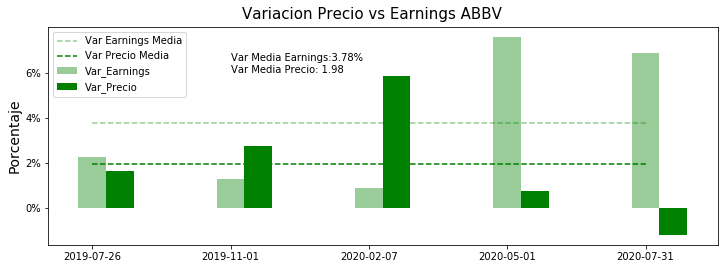

In [30]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

ticker = data.Symbol.loc[0]
title = f'Variacion Precio vs Earnings {ticker}'

fig, axs = plt.subplots(figsize=(12,4), ncols=1, nrows=1)
fig.suptitle(title, size = 15, y = 0.95)

axs.bar(fechas , data.Var_Earnings, label = 'Var_Earnings',width = 0.2, color = 'green', alpha  = 0.4)
axs.plot(fechas, [data.Var_Earnings.mean()]*len(data), color='green', ls='--', label='Var Earnings Media', alpha = 0.4)

axs.bar(data.index + 0.20, data.Var_Precio, label = 'Var_Precio', width = 0.2, color = 'green',alpha  = 1)
axs.plot(fechas, [data.Var_Precio.mean()]*len(data), color='green', ls='--', label='Var Precio Media', alpha  = 1)

#Ejes
plt.ylabel('Porcentaje', size = 14)
plt.xticks(data.index) #es para poner la cantidad de datos en el eje X

#cambio de formato a porcentaje en el eje Y
formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
axs.yaxis.set_major_formatter(formatter)


Earnings_media = round(data.Var_Earnings.mean(),2)
Precio_media = round(data.Var_Precio.mean(),2)
leyenda = 'Var Media Earnings:'+str(Earnings_media)+'%\nVar Media Precio: '+str(Precio_media)
axs.text(s = leyenda, y=6, x=1 , size = 10)


axs.legend()
plt.show()

## Mejoras Posibles al Código

* Ver si el reporte de earnings fue a la mañana/tarde para saber si tomar el precio T o T+1 (ahora toma siempre T)
    * FMP tiene el horario en el endpoint "Earning Call Transcript", pero es pago
* Conseguir una serie histórica más larga (hay 4/5 datos por ticker)